# 미니 경진대회 - 네트워크 침입 여부 예측

본 파일은 경연대회에 참가하시는 모든 참가자 분들에게 제공되는 기본 코드입니다. 따라서 **본인이 원하는 대로 자유롭게 수정하면서 경진대회를 진행하세요.** 

본 코드는 플랫폼 상에서 데이터를 불러오는 방법부터 간단한 전처리 및 머신러닝 모델링 과정을 소개하고 있습니다. 나아가서 작성한 코드의 결과를 플랫폼 상에서 바로 채점하기 위한 과정까지 확인해볼 수 있습니다.

In [1]:
# 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.


In [2]:
# 예시 코드에 필요한 라이브러리를 불러옵니다.
import os

import pandas as pd
import numpy as np # 데이터 조작, 정제, 분석을 위한 데이터 분석 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder

data_dir = "/mnt/elice/dataset"

## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.
  - 데이터셋 구성: Packet Flow rate, Protocol 등 41개의 Feature로 구성된 데이터셋. 
  - 주요 컬럼: Dst Port (Destination port), Protocol, Flow Duration, Tot Fwd Pkts (Total forward packets), Tot Bwd Pkts (Total backward packets)
    - 전체 컬럼에 대한 설명은 경진대회 설명을 확인해주세요.
  - 타겟 변수 (예측해야 하는 대상): Label


In [3]:
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"), index_col="unique_id")
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"), index_col="unique_id")

In [4]:
print("Train Data 크기 :", train_df.shape)
print("Test Data 크기 :", test_df.shape)

Train Data 크기 : (4638804, 42)
Test Data 크기 : (1159701, 42)


# 데이터 확인하기

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4638804 entries, 1143575A to 6700647I
Data columns (total 42 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Dst Port          object 
 1   Protocol          int64  
 2   Timestamp         object 
 3   Flow Duration     int64  
 4   Tot Fwd Pkts      int64  
 5   Tot Bwd Pkts      int64  
 6   TotLen Fwd Pkts   int64  
 7   TotLen Bwd Pkts   float64
 8   Flow Byts/s       float64
 9   Flow Pkts/s       float64
 10  Flow IAT Mean     float64
 11  Flow IAT Std      float64
 12  Flow IAT Max      float64
 13  Flow IAT Min      float64
 14  Pkt Len Min       int64  
 15  Pkt Len Max       int64  
 16  Pkt Len Mean      float64
 17  Pkt Len Std       float64
 18  Pkt Len Var       float64
 19  FIN Flag Cnt      int64  
 20  SYN Flag Cnt      int64  
 21  RST Flag Cnt      int64  
 22  PSH Flag Cnt      int64  
 23  ACK Flag Cnt      int64  
 24  URG Flag Cnt      int64  
 25  CWE Flag Count    int64  
 26  ECE Flag Cn

In [6]:
train_df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Flow Byts/s,Flow Pkts/s,...,Subflow Bwd Byts,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
unique_id,,,,,,,,,,,,,,,,,,,,,
1143575A,B,17,2018-03-01 09:28:38,1920,1,1,47,107.0,80208.333330,1041.666667,...,107,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,Benign
3422448M,B,17,2018-02-23 10:04:12,2307,1,1,39,243.0,122236.671001,866.926745,...,243,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,Benign
7243044R,B,17,2018-03-01 04:31:24,1772,1,1,42,182.0,126410.835200,1128.668172,...,182,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,Benign
9908051J,A,6,2018-02-21 02:15:24,13527,3,4,266,935.0,88785.392180,517.483551,...,935,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,DDOS
5842623U,C,6,2018-02-28 02:22:42,60854466,16,15,1577,4799.0,104.774562,0.509412,...,4799,122370.1667,129788.5834,387300.0,69358.0,10000000.0,16311.0867,10000000.0,9968490.0,Infilteration


이상치와 결측치를 확인해보자. 


In [7]:
# 1. 각 컬럼별 결측치(NaN) 개수 확인
missing_values = train_df.isnull().sum()
# 결측치가 존재하는 컬럼만 필터링해서 출력
missing_values_exist = missing_values[missing_values > 0]

print("\n--- 결측치(NaN)가 존재하는 컬럼 및 개수 ---")
if not missing_values_exist.empty:
    print(missing_values_exist)
else:
    print("결측치(NaN)가 존재하는 컬럼이 없습니다.")

# 2. 숫자형 컬럼에서 inf 값 개수 확인
numeric_df = train_df.select_dtypes(include=[np.number])
inf_counts_numeric = numeric_df.apply(lambda x: np.isinf(x).sum())
# inf 값이 존재하는 컬럼만 필터링해서 출력
inf_counts_exist = inf_counts_numeric[inf_counts_numeric > 0]

print("\n--- inf 값이 존재하는 숫자형 컬럼 및 개수 ---")
if not inf_counts_exist.empty:
    print(inf_counts_exist)
else:
    print("inf 값이 존재하는 숫자형 컬럼이 없습니다.")

# 3. 전체 데이터(행) 개수 확인
total_entries = train_df.shape[0]
print(f"\n--- 전체 데이터(행) 개수: {total_entries} ---")

# --- 결측치 또는 inf 값이 포함된 '고유한 행'의 개수 계산 ---

# 1. NaN 값이 하나라도 있는 행을 True로 표시
nan_rows_mask = train_df.isnull().any(axis=1) # axis=1은 행 기준으로 하나라도 True면 True

# 2. inf 값이 하나라도 있는 행을 True로 표시 (숫자형 컬럼만)
# 모든 컬럼에 np.isinf를 바로 적용하면 TypeError가 날 수 있으므로, 숫자형 컬럼에만 적용 후 합쳐서 판단
inf_rows_mask_numeric = train_df.select_dtypes(include=[np.number]).apply(lambda col: np.isinf(col)).any(axis=1)

# 3. NaN이 있거나 inf가 있는 모든 행의 통합 마스크
# 두 마스크를 OR(|) 연산으로 합쳐서, NaN이나 inf 중 하나라도 있는 행을 모두 True로 표시
problematic_rows_mask = nan_rows_mask | inf_rows_mask_numeric

# 4. 문제성 행의 총 개수 (중복 제외)
total_problematic_rows = problematic_rows_mask.sum()

print("\n--- 결측치 또는 inf 값이 포함된 고유한 행의 개수 및 비율 ---")
print(f"결측치(NaN) 또는 inf 값이 포함된 고유한 행의 총 개수: {total_problematic_rows}개")

if total_entries > 0:
    problematic_ratio = (total_problematic_rows / total_entries * 100)
    print(f"전체 데이터 대비 고유한 문제성 행의 비율: {problematic_ratio:.4f}%")
else:
    print("데이터가 비어있어 비율을 계산할 수 없습니다.")


--- 결측치(NaN)가 존재하는 컬럼 및 개수 ---
Flow Byts/s    9
dtype: int64

--- inf 값이 존재하는 숫자형 컬럼 및 개수 ---
Flow Byts/s    597
Flow Pkts/s    606
dtype: int64

--- 전체 데이터(행) 개수: 4638804 ---

--- 결측치 또는 inf 값이 포함된 고유한 행의 개수 및 비율 ---
결측치(NaN) 또는 inf 값이 포함된 고유한 행의 총 개수: 606개
전체 데이터 대비 고유한 문제성 행의 비율: 0.0131%


매우 작은 값이므로 해당 행을 제거한다. 

In [8]:
print(f"--- 제거 전 데이터 행 개수: {train_df.shape[0]} ---")

# 1. 'Flow Byts/s' 컬럼의 inf (양의 무한대 또는 음의 무한대) 값을 NaN으로 변환
# np.inf와 -np.inf를 동시에 처리
train_df['Flow Byts/s'] = train_df['Flow Byts/s'].replace([np.inf, -np.inf], np.nan)

# 2. 'Flow Pkts/s' 컬럼의 inf 값을 NaN으로 변환
train_df['Flow Pkts/s'] = train_df['Flow Pkts/s'].replace([np.inf, -np.inf], np.nan)

# 3. 이제 NaN이 된 값들을 가진 행들을 제거
# subset에 두 컬럼을 모두 지정해서, 이 두 컬럼 중 하나라도 NaN이면 해당 행을 제거
# inplace=True를 사용하면 원본 DataFrame을 바로 수정하지만, 여기서는 새로운 DataFrame을 만드는 걸 권장.
# 학습용 데이터를 변경하는 것이므로, 새 변수에 할당하여 관리하는 것이 더 안전하고 명확해.
train_df_cleaned = train_df.dropna(subset=['Flow Byts/s', 'Flow Pkts/s'])

print(f"--- 제거 후 데이터 행 개수: {train_df_cleaned.shape[0]} ---")

# 제대로 제거되었는지 다시 한번 확인 (생략해도 되지만, 확실히 보려면!)
cleaned_missing_values = train_df_cleaned.isnull().sum()
cleaned_inf_counts_numeric = train_df_cleaned.select_dtypes(include=[np.number]).apply(lambda x: np.isinf(x).sum())
print("\n--- 제거 후 결측치 및 inf 값 확인 ---")
print(cleaned_missing_values[cleaned_missing_values > 0])
print(cleaned_inf_counts_numeric[cleaned_inf_counts_numeric > 0])

--- 제거 전 데이터 행 개수: 4638804 ---
--- 제거 후 데이터 행 개수: 4638198 ---

--- 제거 후 결측치 및 inf 값 확인 ---
Series([], dtype: int64)
Series([], dtype: int64)


네트워크의 침임여부를 분류하려면 비정상 통신의 특징을 알아야한다고 생각했다.
따라서 label 컬럼이 가리키고 있는 각 값과 다른 컬럼들과의 상관관계를 확인해보자.

상관관계를 확인하기에 앞서 Object type인 Dst Port, Timestamp의 형태를 바꾸자.

In [9]:
train_df['Dst Port'].unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

Dst Port의 값이 A, B, C, D, E, F, G로 나누어져 있다.

1) A부터 G까지 독립적인 의미를 가지는 포트 번호의 값
2) 서로 간에 순서나 크기를 나타내는 값이 아님
> 원-핫 인코딩이 적절한 듯 보인다. 

In [10]:
# 1. 'Timestamp' 컬럼을 날짜/시간(datetime) 타입으로 변환 (이건 원본에 바로 적용해도 괜찮아)
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'], errors='coerce')

# --- 여기부터 복사본 사용! ---

# 2. train_df의 복사본 만들기! 📋
# 이제부터 모든 전처리 작업은 train_df_processed에 할 거야.
train_df_processed = train_df.copy()

# 3. 'Dst Port' 컬럼 원-핫 인코딩 (복사본에 적용) ✨
train_df_processed = pd.get_dummies(train_df_processed, columns=['Dst Port'], prefix='Dst_Port', drop_first=True)

print("--- 최종 train_df_processed 컬럼 목록 ---")
print(train_df_processed.columns)
print("\n")

print("--- 최종 DataFrame 정보 ---")
print(train_df_processed.info()) # Dst Port 컬럼이 여전히 그대로 있을 거야

--- 최종 train_df_processed 컬럼 목록 ---
Index(['Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       'Subflow Bwd Byts', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label',
       'Dst_Port_B', 'Dst_Port_C', 'Dst_Port_D', 'Dst_Port_E', 'Dst_Port_F',
       'Dst_Port_G'],
      dtype='object')


--- 최종 DataFrame 정보 ---
<class 'pandas.core.frame.DataFrame'>
Index: 4638804 entries, 1143575A to 6700647I
Data columns (total 47 

상관계수로 관계를 확인하고 싶었지만 Label 컬럼을 레이블 인코딩해야하는데 모델이 부여된 숫자에 순서나 크기 관계가 있다고 착각할 수 있음.

따라서 통계량 비교나 시각화를 활용하는 것이 좋겠다.

## 1. 통계량 비교

In [11]:
# --- 판다스 출력 옵션 설정 ---
# 모든 컬럼을 볼 수 있도록 최대 컬럼 수를 늘려줘
pd.set_option('display.max_columns', None)
# DataFrame이 잘리지 않도록 표시 너비를 충분히 늘려줘
pd.set_option('display.width', 100)

In [12]:
features_to_compare_simultaneously = [
    'Protocol',
    'Flow Duration',
    'Tot Fwd Pkts',
    'Tot Bwd Pkts',
    'TotLen Fwd Pkts',
    'TotLen Bwd Pkts',
    'Flow Byts/s',
    'Flow Pkts/s',
    'Flow IAT Mean',
    'Flow IAT Std',
    'Flow IAT Max',
    'Flow IAT Min',
    'Pkt Len Mean',
    'Pkt Len Std',
    'Pkt Len Max',
    'Pkt Len Min',
    'Pkt Len Var',
    'FIN Flag Cnt',
    'SYN Flag Cnt',
    'RST Flag Cnt',
    'PSH Flag Cnt',
    'ACK Flag Cnt',
    'URG Flag Cnt',
    'ECE Flag Cnt',
    'CWE Flag Count',
    'Down/Up Ratio',
    'Pkt Size Avg',
    'Subflow Fwd Pkts',
    'Subflow Fwd Byts',
    'Subflow Bwd Pkts',
    'Subflow Bwd Byts',
    'Active Mean',
    'Active Std',
    'Active Max',
    'Active Min',
    'Idle Mean',
    'Idle Std',
    'Idle Max',
    'Idle Min',
    'Dst_Port_B',
    'Dst_Port_C',
    'Dst_Port_D',# Dst_Port 관련 Feature도 중요하니 포함
    'Dst_Port_E',
    'Dst_Port_F',
    'Dst_Port_G'
]

# 각 Feature에 대해 계산하고 싶은 통계량들을 딕셔너리 형태로 정의
# '컬럼명': ['통계량1', '통계량2', ...]
aggregation_dict = {col: ['mean', 'median', 'std', 'min', 'max'] for col in features_to_compare_simultaneously}

# 'Label' 컬럼을 기준으로 그룹화하고, 정의된 통계량들을 한 번에 계산
# .T (Transpose)를 사용하면 Label이 행으로, Feature_Statistic이 컬럼으로 나와서 보기 편해.
comparison_table = train_df_processed.groupby('Label').agg(aggregation_dict)

# 멀티 인덱스 컬럼을 더 보기 좋게 만들기 (선택 사항)
# 예를 들어, 'Flow Duration', 'mean' -> 'Flow Duration_mean'
comparison_table.columns = ['_'.join(col).strip() for col in comparison_table.columns.values]

print("--- 각 Label 그룹별 핵심 Feature 통계치 동시 비교 ---")
print(comparison_table)

--- 각 Label 그룹별 핵심 Feature 통계치 동시 비교 ---
               Protocol_mean  Protocol_median  Protocol_std  Protocol_min  Protocol_max  \
Label                                                                                     
Benign             10.108137              6.0      5.320970             6            17   
Brute Force         6.000000              6.0      0.000000             6             6   
DDOS                6.027670              6.0      0.551006             6            17   
DoS                 6.000000              6.0      0.000000             6             6   
Infilteration      11.016032              6.0      5.478703             6            17   

               Flow Duration_mean  Flow Duration_median  Flow Duration_std  Flow Duration_min  \
Label                                                                                           
Benign               1.384660e+07               80999.0       3.265167e+07                  0   
Brute Force          1.126462e

### 1. Benign (정상 통신):

다양한 Protocol 사용 (TCP, UDP).

Flow Duration은 대부분 짧지만, 매우 긴 이상치 존재.

Tot Fwd Pkts/TotLen Fwd Pkts, Tot Bwd Pkts/TotLen Bwd Pkts가 양방향으로 균형 있게 발생.

Flow Pkts/s는 공격 유형보다 낮음.

Flow IAT는 가변적이고 긴 유휴 시간이 존재.

Pkt Len Mean/Max가 공격 유형보다 높음 (상대적으로 긴 패킷).

Down/Up Ratio가 양방향 통신을 나타냄.

Active/Idle 시간이 의미 있는 값을 가짐.

Dst_Port는 B, C, D, F 등 다양한 포트를 낮은 비율로 사용.

### 2. Brute Force (브루트 포스 공격):

오직 TCP (Protocol: 6) 사용.

매우 짧은 Flow Duration (median: 6.0).

압도적으로 높은 Flow Pkts/s (median: 333333).

매우 낮은 Pkt Len Mean/Max/Min (median: 0.0).

높은 Down/Up Ratio (median: 1.0).

모든 Active/Idle 관련 Feature가 0.0 (끊김 없는 공격).

높은 PSH Flag Cnt (median: 1.0) 및 URG Flag Cnt (mean: 0.245).

SYN Flag Cnt가 0.0.

Dst_Port_E와 Dst_Port_G에 압도적으로 집중 (median: 1.0 또는 mean: 0.491).

### 3. DDOS (분산 서비스 거부 공격):

대부분 TCP이나 일부 UDP 포함.

매우 짧은 Flow Duration (median: 6588.0).

압도적으로 높은 Tot Fwd Pkts/TotLen Fwd Pkts (mean 기준).

매우 낮은 Tot Bwd Pkts/TotLen Bwd Pkts (median: 0.0) 및 Down/Up Ratio (median: 0.0) (단방향 공격).

모든 Active/Idle 관련 Feature가 0.0 (끊김 없는 공격).

높은 ACK Flag Cnt (median: 1.0).

SYN Flag Cnt가 0.0.

우리가 정의한 Dst_Port Feature들에서 특정 포트 집중 경향이 없음 (mean: 0.0).
### 4. DoS (서비스 거부 공격):

오직 TCP (Protocol: 6) 사용.

Flow Duration은 짧지만, 매우 긴 이상치 존재.

매우 높은 Flow Pkts/s (mean: 154291).

가장 낮은 Pkt Len Mean/Max/Min (median: 0.0).

매우 낮은 Tot Bwd Pkts/TotLen Bwd Pkts (median: 0.0) 및 Down/Up Ratio (median: 0.0) (단방향 공격).

Idle Mean은 높지만 median은 0.0 (일부 흐름에 긴 유휴 시간 이상치 존재).

높은 ACK Flag Cnt (median: 1.0).

Dst_Port_E에 집중 (mean: 0.207).

### 5. Infilteration (침투 공격):

다양한 Protocol 사용 (TCP, UDP).

Flow Duration은 대부분 짧지만, 매우 긴 이상치 존재.

Tot Fwd Pkts/TotLen Fwd Pkts, Tot Bwd Pkts/TotLen Bwd Pkts가 양방향으로 균형 있게 발생.

Flow Pkts/s는 공격 유형보다 낮음.

Flow IAT는 가변적이고 긴 유휴 시간이 존재.

Pkt Len Mean/Max가 공격 유형보다 높음 (상대적으로 긴 패킷).

Down/Up Ratio가 양방향 통신을 나타냄.

Active/Idle 시간이 의미 있는 값을 가짐.

RST Flag Cnt가 상대적으로 높음.

Dst_Port는 B, C, D, F 등 다양한 포트를 낮은 비율로 사용하며, 특히 Dst_Port_C에서 Benign보다 높은 비율을 보임.

## Feature 선택 전략
1. 중복되거나 정보 가치가 낮은 Feature 제거 (Redundancy & Low Variance)
1) Subflow 관련 Feature
-Tot Fwd Pkts/TotLen Fwd Pkts와 Tot Bwd Pkts/TotLen Bwd Pkts와 Subflow 관련 Feature들이 거의 동일한 통계치를 보였잖아. 이건 정보의 중복성이 높다는 의미야.
- 대부분의 Flow가 단일 Subflow로 구성: 실제 네트워크 트래픽에서는 모든 Flow가 여러 Subflow를 가지는 건 아니야. 특히 악성 트래픽의 경우, 단순하고 일방적인 통신(예: DoS, Brute Force)이 많아서 대부분의 Flow가 하나의 Subflow로만 구성될 수 있어. 이 경우 Subflow의 통계치는 Tot Flow의 통계치와 같아지겠지.
- Tot Flow 관련 Feature만 남기기

2) min/max 값이 False/True로만 나오는 Feature: Dst_Port 관련 Feature들처럼 min이 False이고 max가 True인 경우가 많았지? 이건 해당 Feature가 이진 값(0 또는 1)으로만 구성되어 있다는 뜻이야. 이 경우 std (표준편차)나 mean (평균)만으로도 충분히 정보가 전달되니까, min/max 컬럼 자체는 굳이 남길 필요가 없을 수도 있어. 어떻게 생각해?

2. 분산이 너무 낮거나 (거의 상수) 너무 높은 Feature 고려 (Variance)
분산이 너무 낮은 Feature: 만약 어떤 Feature의 std (표준편차)가 거의 0에 가깝다면, 그 Feature는 모든 샘플에서 거의 같은 값을 가진다는 의미야. 이런 Feature는 모델 학습에 큰 도움이 되지 않을 수 있어서 제거를 고려해볼 수 있어. (예: Brute Force나 DDOS에서 Protocol의 std가 0.0인 것처럼, 특정 그룹 내에서는 분산이 없지만 그룹 간에는 차이가 있는 경우는 유용함)


높은 패턴 기여도:

요일: 네트워크 트래픽이나 공격 패턴은 요일에 따라 크게 달라지는 경향이 있어. 예를 들어, 주중 업무 시간과 주말에는 정상 트래픽 패턴이 다를 거고, 공격자들도 특정 요일에 활동을 집중하거나(예: 주말 새벽을 노린다든지) 하는 패턴을 보일 수 있어.

시간 (하루 중): 요일만큼이나 하루 중 특정 시간대도 중요한 패턴을 보여줘. 업무 시간, 퇴근 후 저녁 시간, 심야 시간 등에 따라 정상 트래픽 양이 달라지고, 이에 맞춰 공격자들이 특정 시간대에 공격을 시도하는 경향이 흔하거든.

물론, 지금은 요일과 시간만 추출했지만, 만약 모델 학습 후에 시간 관련 Feature가 부족하다는 판단이 들거나, 더 깊은 시간 기반의 패턴을 찾아야 할 필요가 있다면 언제든지 월, 주차 등 다른 시간 단위 Feature를 추가로 추출해서 실험해볼 수 있어. 이건 데이터 분석 과정에서 유연하게 가져갈 수 있는 부분이야!

In [13]:
# 'Label' 컬럼은 타겟 변수이므로 표준편차 계산에서 제외
# 숫자형이 아닌 컬럼도 오류를 피하기 위해 제외
numeric_cols = train_df_processed.select_dtypes(include=['number']).columns
if 'Label' in numeric_cols:
    numeric_cols = numeric_cols.drop('Label')

feature_std_dev = train_df_processed[numeric_cols].std()

# 결과 출력
print("✨ 각 Feature의 표준편차 ✨")
print(feature_std_dev)

# 표준편차가 매우 낮은 Feature들을 확인하기 쉽게 정렬해서 볼 수도 있어
print("\n🔍 표준편차가 낮은 순서대로 정렬 (상위 20개) 🔍")
print(feature_std_dev.sort_values().head(20))

✨ 각 Feature의 표준편차 ✨
Protocol            4.851799e+00
Flow Duration       2.849253e+07
Tot Fwd Pkts        2.090040e+03
Tot Bwd Pkts        2.023753e+02
TotLen Fwd Pkts     6.833095e+04
TotLen Bwd Pkts     2.878768e+05
Flow Byts/s         1.718679e+06
Flow Pkts/s         2.766265e+05
Flow IAT Mean       7.868658e+06
Flow IAT Std        3.665552e+06
Flow IAT Max        1.349822e+07
Flow IAT Min        7.707859e+06
Pkt Len Min         1.861272e+01
Pkt Len Max         5.219616e+02
Pkt Len Mean        1.117876e+02
Pkt Len Std         1.632848e+02
Pkt Len Var         1.105778e+05
FIN Flag Cnt        4.473279e-02
SYN Flag Cnt        1.586393e-01
RST Flag Cnt        3.427082e-01
PSH Flag Cnt        4.961815e-01
ACK Flag Cnt        4.568959e-01
URG Flag Cnt        1.407957e-01
CWE Flag Count      6.500038e-03
ECE Flag Cnt        3.427086e-01
Down/Up Ratio       7.590810e-01
Pkt Size Avg        1.154884e+02
Subflow Fwd Pkts    2.090040e+03
Subflow Fwd Byts    6.833095e+04
Subflow Bwd Pkts    2.0

1. 네가 정렬한 표준편차가 낮은 순서대로 정렬 (상위 20개) 부분을 보자.

CWE Flag Count (0.006500):

CWE Flag Count는 제거를 강력히 고려해볼 만한 Feature야. 대부분의 데이터에서 거의 변화가 없을 가능성이 높아 모델 학습에 기여하는 바가 적을 거야.

나머지 Flag Count Feature들 (FIN Flag Cnt, URG Flag Cnt, SYN Flag Cnt, RST Flag Cnt, ECE Flag Cnt, ACK Flag Cnt, PSH Flag Cnt)은 비록 표준편차가 0에 가깝지만, 우리 초기 분석에서 특정 공격 유형(예: Brute Force의 PSH, ACK Flag)에서 유의미한 패턴을 보였던 것을 기억해야 해. 이 Feature들은 각 Label 그룹 내에서는 분산이 낮을 수 있어도, Label 간에는 중요한 차이를 만들어내므로 제거하지 않고 유지하는 것이 더 좋을 것 같아.

2.나중에 전처리할 Feature: 표준편차가 높은 Flow Duration, Tot Fwd Pkts, Tot Bwd Pkts, TotLen Fwd Pkts, TotLen Bwd Pkts, Flow Byts/s, Flow Pkts/s, Flow IAT 관련 Feature들, Pkt Len 관련 Feature들, Active 및 Idle 관련 Feature들은 나중에 로그 변환 및 스케일링을 통해 값의 범위를 조정해야 해.


In [14]:
# --- 1. Subflow 관련 Feature 제거 ---
columns_to_drop_subflow = [col for col in train_df_processed.columns if col.startswith('Subflow')]
if columns_to_drop_subflow: # 제거할 컬럼이 있을 경우에만 drop 수행
    train_df_processed = train_df_processed.drop(columns=columns_to_drop_subflow)
    print(f"1. Subflow 관련 Feature {columns_to_drop_subflow} 제거 완료. ✅")
else:
    print("1. Subflow 관련 Feature가 없습니다. (이미 제거되었거나 해당 컬럼 없음)")


# --- 2. Dst_Port min/max 컬럼 제거 ---
columns_to_drop_dst_port_minmax = [col for col in train_df_processed.columns if col.startswith('Dst_Port_') and (col.endswith('_min') or col.endswith('_max'))]
if columns_to_drop_dst_port_minmax: # 제거할 컬럼이 있을 경우에만 drop 수행
    train_df_processed = train_df_processed.drop(columns=columns_to_drop_dst_port_minmax)
    print(f"2. Dst_Port min/max 컬럼 {columns_to_drop_dst_port_minmax} 제거 완료. ✅")
else:
    print("2. Dst_Port min/max 컬럼이 없습니다. (이미 제거되었거나 해당 컬럼 없음)")


# --- 3. (초기 필터링) 모든 Label 그룹에서 분산이 극도로 낮은 Feature 제거 ---
# 이 단계는 Timestamp 처리 전에 숫자형 컬럼에서 불필요한 것들을 미리 거릅니다.
low_variance_cols_initial = []
for col in train_df_processed.columns:
    if col == 'Label': # Label 컬럼은 제외
        continue
    if pd.api.types.is_numeric_dtype(train_df_processed[col]):
        # std() 값이 0에 극도로 가까운 (예: 0.00001 미만) 컬럼 제거
        if train_df_processed[col].std() < 0.00001:
            low_variance_cols_initial.append(col)
if low_variance_cols_initial:
    train_df_processed = train_df_processed.drop(columns=low_variance_cols_initial)
    print(f"3. 초기 분산이 극도로 낮은 Feature {low_variance_cols_initial} 제거 완료. ✅")
else:
    print("3. 초기 분산이 극도로 낮은 Feature가 없습니다.")


# --- 4. CWE Flag Count Feature 제거 ---
column_to_drop_cwe = ['CWE Flag Count']
if column_to_drop_cwe[0] in train_df_processed.columns:
    train_df_processed = train_df_processed.drop(columns=column_to_drop_cwe)
    print(f"4. '{column_to_drop_cwe[0]}' 컬럼이 성공적으로 제거되었습니다. ✅")
else:
    print(f"4. '{column_to_drop_cwe[0]}' 컬럼이 데이터프레임에 없습니다. (이미 제거되었거나 이름이 다를 수 있습니다.)")


# --- 5. Timestamp 컬럼 처리 (가장 중요! 여기서 Day_of_Week, Hour_of_Day 생성) ---
# 'Timestamp' 컬럼이 문자열이라면 datetime 객체로 변환
if 'Timestamp' in train_df_processed.columns:
    train_df_processed['Timestamp'] = pd.to_datetime(train_df_processed['Timestamp'])
    train_df_processed['Day_of_Week'] = train_df_processed['Timestamp'].dt.dayofweek
    train_df_processed['Hour_of_Day'] = train_df_processed['Timestamp'].dt.hour
    train_df_processed = train_df_processed.drop(columns=['Timestamp'])
    print("5. Timestamp 컬럼 처리 및 Day_of_Week, Hour_of_Day 생성 완료. ✅")
else:
    print("5. 'Timestamp' 컬럼이 데이터프레임에 없습니다. Timestamp 처리를 건너뜁니다.")


# --- 6. (재확인) 모든 Label 그룹에서 분산이 극도로 낮은 Feature 제거 (Timestamp 처리 후 최종 필터링) ---
# Timestamp 처리 후 새로 생성된 컬럼 (Day_of_Week, Hour_of_Day)의 분산도 여기에 포함하여 확인 가능
# 위 3번에서 제거되지 않았고 Timestamp 관련 컬럼이 아니었던 나머지 저분산 컬럼들이 여기서 제거될 수 있습니다.
low_variance_cols_final = []
for col in train_df_processed.columns:
    if col == 'Label': # Label 컬럼은 제외
        continue
    if pd.api.types.is_numeric_dtype(train_df_processed[col]):
        if train_df_processed[col].std() < 0.00001:
            # Day_of_Week와 Hour_of_Day는 여기서 제외 (수동으로)
            # 이들은 숫자로 표현되지만 범주형 또는 순서형 의미가 강하여 분산이 낮더라도 유지
            if col not in ['Day_of_Week', 'Hour_of_Day']:
                low_variance_cols_final.append(col)

if low_variance_cols_final:
    train_df_processed = train_df_processed.drop(columns=low_variance_cols_final)
    print(f"6. 최종 분산이 극도로 낮은 Feature {low_variance_cols_final} 제거 완료. ✅")
else:
    print("6. 최종 분산이 극도로 낮은 Feature가 없습니다.")


# --- 7. 로그 변환 (고분산 및 왜곡된 분포 컬럼) ---
cols_to_log_transform = [
    'Flow Duration', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
    'Flow Byts/s', 'Flow Pkts/s', 'Pkt Len Var',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Active Mean', 'Active Std', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'
]
cols_to_log_transform = [col for col in cols_to_log_transform if col in train_df_processed.columns] # 실제 존재하는 컬럼만 선택

print(f"\n7. 로그 변환을 적용할 컬럼: {cols_to_log_transform}")
for col in cols_to_log_transform:
    # 런타임 경고 방지를 위해 음수 값이나 NaN이 발생하지 않도록 확인하거나 처리 필요.
    # np.log1p는 x >= -1일 때 동작, 0이하 값에 대한 처리 필요시 np.where 사용 고려
    train_df_processed[col] = np.log1p(train_df_processed[col])
print("7. 로그 변환 적용 완료. ✅")


# --- 8. StandardScaler (Label, Day_of_Week, Hour_of_Day 제외한 모든 숫자형 컬럼) ---
cols_to_scale = train_df_processed.select_dtypes(include=['number']).columns.tolist()
if 'Label' in cols_to_scale: cols_to_scale.remove('Label')
if 'Day_of_Week' in cols_to_scale: cols_to_scale.remove('Day_of_Week')
if 'Hour_of_Day' in cols_to_scale: cols_to_scale.remove('Hour_of_Day')

print(f"\n8. StandardScaler를 적용할 컬럼 (Label, Day_of_Week, Hour_of_Day 제외): {cols_to_scale}")

scaler = StandardScaler()
train_df_processed[cols_to_scale] = scaler.fit_transform(train_df_processed[cols_to_scale])

print("\n✨ 모든 전처리 단계 완료! ✨")## 1. CWE Flag Count Feature 제거
column_to_drop_cwe = ['CWE Flag Count']

# 컬럼이 데이터프레임에 존재하는지 확인 후 제거 (오류 방지)
if column_to_drop_cwe[0] in train_df_processed.columns:
    train_df_processed = train_df_processed.drop(columns=column_to_drop_cwe)
    print(f"'{column_to_drop_cwe[0]}' 컬럼이 성공적으로 제거되었습니다. ✅")
else:
    print(f"'{column_to_drop_cwe[0]}' 컬럼이 데이터프레임에 없습니다. 이미 제거되었거나 이름이 다를 수 있습니다.")

## 2. 스케일링
# --- 4. Timestamp 컬럼 처리 (먼저 수행! 중요!) ---
# 'Timestamp' 컬럼이 문자열이라면 datetime 객체로 변환
# 주의: 'Timestamp' 컬럼이 존재한다고 가정
if 'Timestamp' in train_df_processed.columns:
    train_df_processed['Timestamp'] = pd.to_datetime(train_df_processed['Timestamp'])
    train_df_processed['Day_of_Week'] = train_df_processed['Timestamp'].dt.dayofweek
    train_df_processed['Hour_of_Day'] = train_df_processed['Timestamp'].dt.hour
    train_df_processed = train_df_processed.drop(columns=['Timestamp'])
    print("4. Timestamp 컬럼 처리 및 Day_of_Week, Hour_of_Day 생성 완료.")
else:
    print("4. 'Timestamp' 컬럼이 데이터프레임에 없습니다. Timestamp 처리를 건넙니다.")

# --- 5. 모든 Label 그룹에서 분산이 극도로 낮은 Feature 제거 (이제 Timedelta 없음) ---
# 이전에 발생했던 TypeError 방지를 위해 TimeDelta 컬럼이 없음을 확인
low_variance_cols = []
for col in train_df_processed.columns:
    if col == 'Label': # Label 컬럼은 제외
        continue
    # 숫자형 컬럼만 표준편차를 계산
    if pd.api.types.is_numeric_dtype(train_df_processed[col]):
        # std() 값이 0에 극도로 가까운 (예: 0.00001 미만) 컬럼 제거
        if train_df_processed[col].std() < 0.00001:
            low_variance_cols.append(col)
train_df_processed = train_df_processed.drop(columns=low_variance_cols)
print(f"5. 분산이 극도로 낮은 Feature {low_variance_cols} 제거 완료.")

# --- 6. 로그 변환 (고분산 및 왜곡된 분포 컬럼) ---
cols_to_log_transform = [
    'Flow Duration', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
    'Flow Byts/s', 'Flow Pkts/s', 'Pkt Len Var',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Active Mean', 'Active Std', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'
]
cols_to_log_transform = [col for col in cols_to_log_transform if col in train_df_processed.columns] # 실제 존재하는 컬럼만 선택

print(f"\n6. 로그 변환을 적용할 컬럼: {cols_to_log_transform}")
for col in cols_to_log_transform:
    train_df_processed[col] = np.log1p(train_df_processed[col])
    # print(f"'{col}' 컬럼에 로그 변환 적용 완료.") # 너무 길어져서 주석 처리

print("6. 로그 변환 적용 완료.")

# --- 7. StandardScaler (Label, Day_of_Week, Hour_of_Day 제외한 모든 숫자형 컬럼) ---
# 이제 Day_of_Week와 Hour_of_Day는 스케일링 대상에서 제외!
cols_to_scale = train_df_processed.select_dtypes(include=['number']).columns.tolist()
if 'Label' in cols_to_scale: cols_to_scale.remove('Label')
if 'Day_of_Week' in cols_to_scale: cols_to_scale.remove('Day_of_Week')
if 'Hour_of_Day' in cols_to_scale: cols_to_scale.remove('Hour_of_Day')

print(f"\n7. StandardScaler를 적용할 컬럼 (Label, Day_of_Week, Hour_of_Day 제외): {cols_to_scale}")

scaler = StandardScaler()
train_df_processed[cols_to_scale] = scaler.fit_transform(train_df_processed[cols_to_scale])

print("\n✨ 모든 전처리 단계 완료! ✨")

1. Subflow 관련 Feature ['Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts'] 제거 완료. ✅
2. Dst_Port min/max 컬럼이 없습니다. (이미 제거되었거나 해당 컬럼 없음)
3. 초기 분산이 극도로 낮은 Feature가 없습니다.
4. 'CWE Flag Count' 컬럼이 성공적으로 제거되었습니다. ✅
5. Timestamp 컬럼 처리 및 Day_of_Week, Hour_of_Day 생성 완료. ✅
6. 최종 분산이 극도로 낮은 Feature가 없습니다.

7. 로그 변환을 적용할 컬럼: ['Flow Duration', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Flow Byts/s', 'Flow Pkts/s', 'Pkt Len Var', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']


/home/elicer/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


7. 로그 변환 적용 완료. ✅

8. StandardScaler를 적용할 컬럼 (Label, Day_of_Week, Hour_of_Day 제외): ['Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

✨ 모든 전처리 단계 완료! ✨
'CWE Flag Count' 컬럼이 데이터프레임에 없습니다. 이미 제거되었거나 이름이 다를 수 있습니다.
4. 'Timestamp' 컬럼이 데이터프레임에 없습니다. Timestamp 처리를 건넙니다.
5. 분산이 극도로 낮은 Feature [] 제거 완료.

6. 로그 변환을 적용할 컬럼: ['Flow Duration', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Flow Byts/s', 'Flow Pkts/s', 'Pkt Len Var', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Active Mean', 'Active Std', 'Active Max', 'Ac

/home/elicer/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


6. 로그 변환 적용 완료.

7. StandardScaler를 적용할 컬럼 (Label, Day_of_Week, Hour_of_Day 제외): ['Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

✨ 모든 전처리 단계 완료! ✨


그리고 day_of_week와 hour_of_day가 Label에 미치는 영향을 확인해보자

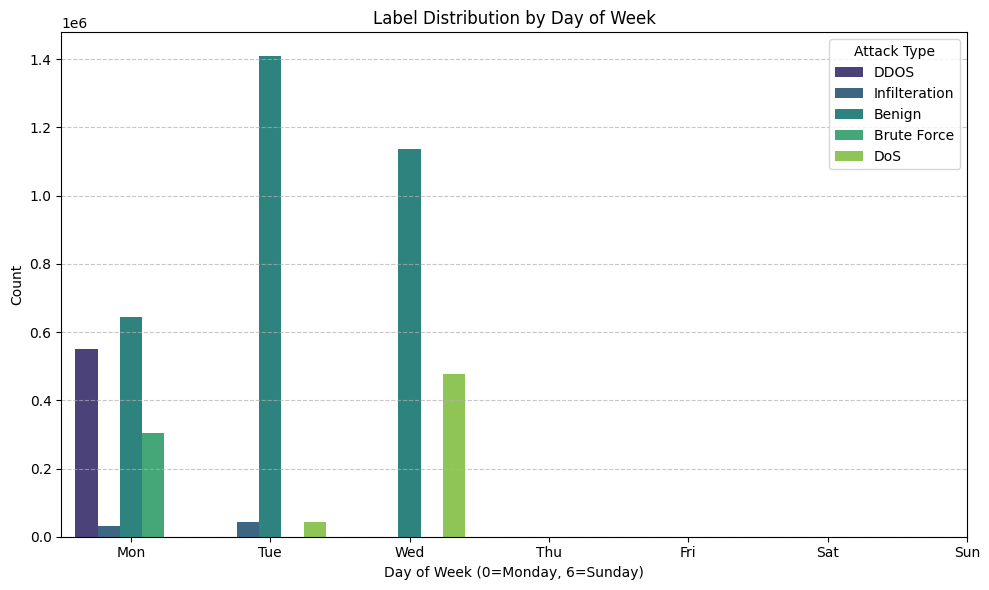

---

최종 'Hour_of_Day' 컬럼 정보 확인:
데이터 타입: int32
고유 값 및 빈도:
Hour_of_Day
1     715042
2     944419
3     340185
4     278241
5     137179
8     259617
9     452648
10    576060
11    565827
12    369586
Name: count, dtype: int64


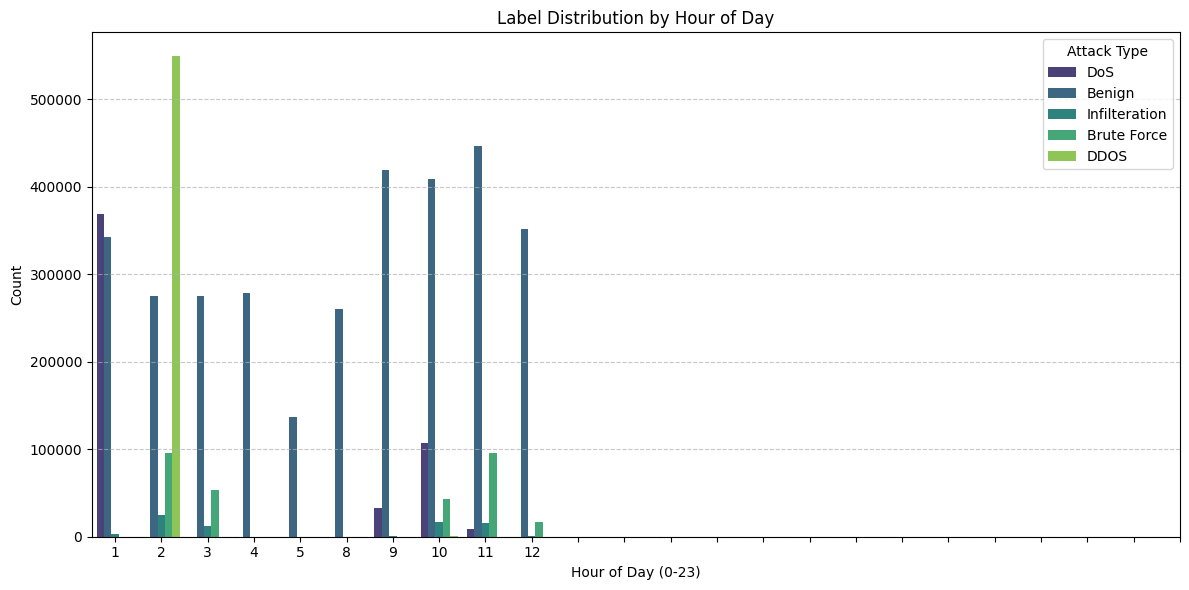

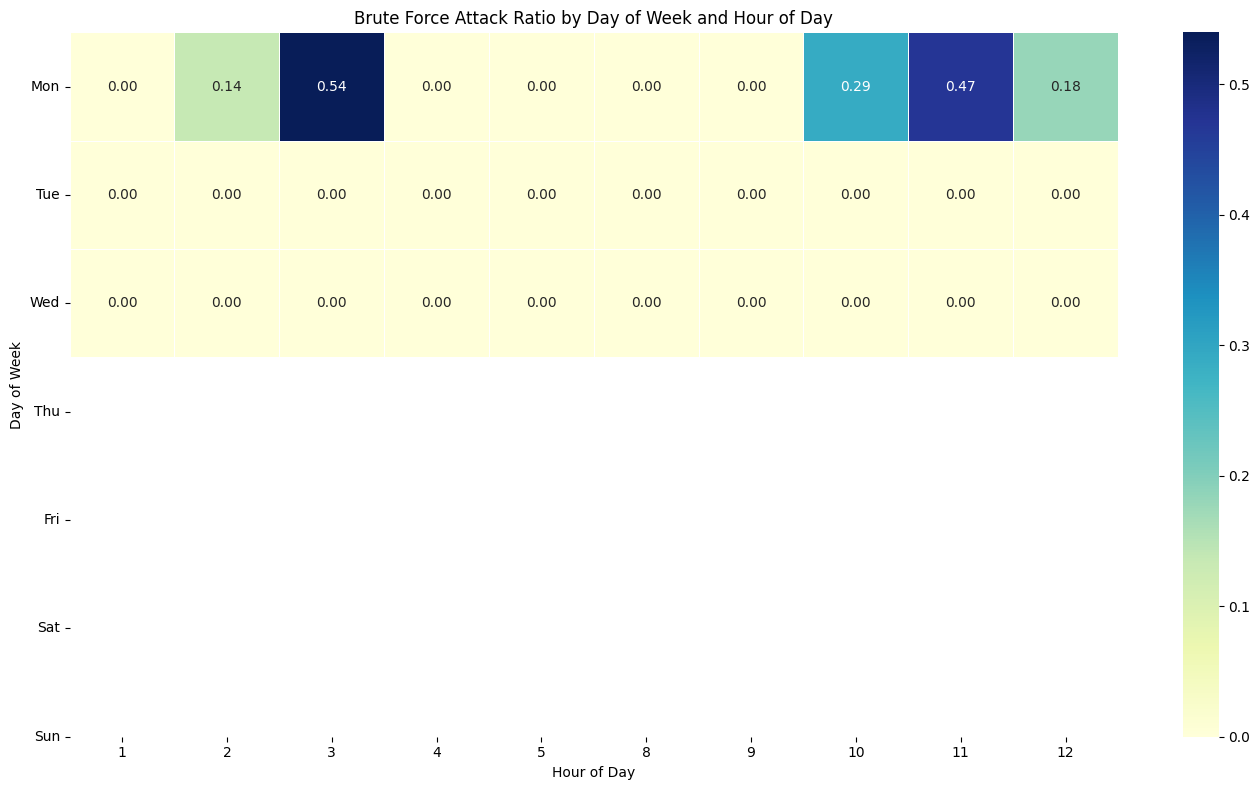

In [15]:
# 1. 요일별 Label 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df_processed, x='Day_of_Week', hue='Label', palette='viridis')
plt.title('Label Distribution by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(title='Attack Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("---") # 시각화 구분선

# -------------------------------------------------------------
# --- 최종 'Hour_of_Day' 확인 및 시각화 (X축이 제대로 나오는지 확인) ---
print("\n최종 'Hour_of_Day' 컬럼 정보 확인:")
print(f"데이터 타입: {train_df_processed['Hour_of_Day'].dtype}")
print("고유 값 및 빈도:")
print(train_df_processed['Hour_of_Day'].value_counts().sort_index())

plt.figure(figsize=(12, 6))
sns.countplot(data=train_df_processed, x='Hour_of_Day', hue='Label', palette='viridis')
plt.title('Label Distribution by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Count')
plt.xticks(range(0, 24)) # 0시부터 23시까지 모든 시간 표시
plt.legend(title='Attack Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 3. 추가 시각화 (선택 사항): 요일 및 시간대별 공격 비율 (더 심층적인 분석)
# 특정 Label의 비율을 보고 싶을 때 유용

# 예시: 'Brute Force' 공격이 요일/시간대별로 어떻게 분포하는지 히트맵으로 보기
# 먼저 각 요일, 시간대, 라벨별 카운트 계산
df_pivot = train_df_processed.groupby(['Day_of_Week', 'Hour_of_Day', 'Label']).size().unstack(fill_value=0)

# 특정 라벨에 대한 비율 계산 (예: Brute Force)
if 'Brute Force' in df_pivot.columns:
    df_pivot['Brute Force_Ratio'] = df_pivot['Brute Force'] / df_pivot.sum(axis=1)
    df_brute_force_heatmap = df_pivot['Brute Force_Ratio'].unstack(level='Hour_of_Day')

    plt.figure(figsize=(14, 8))
    sns.heatmap(df_brute_force_heatmap, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5)
    plt.title('Brute Force Attack Ratio by Day of Week and Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
    plt.tight_layout()
    plt.show()

 Day_of_Week와 Hour_of_Day는 현재 train set에서 Label과 매우 강한 상관관계를 보여주고 있어. 이런 강력한 신호를 단순히 "테스트 세트에 없을 수도 있으니"라는 이유로 제거하는 것은 정보의 손실이 너무 커서 아쉬울 수 있어.

💡 Day_of_Week와 Hour_of_Day를 다루는 최적의 전략 (경진대회용)
이런 상황에서는 단순히 제거하거나 정수형으로 두는 것보다, 시간의 주기성을 모델에 더 잘 알려주는 방법을 사용하는 것이 훨씬 유리해. 바로 사인(Sine) 및 코사인(Cosine) 변환을 이용한 주기적 Feature 변환이야.

왜 이 방법이 좋을까?

주기성 반영: 시간(23시 다음은 0시)과 요일(일요일 다음은 월요일)은 순환하는 특성을 가지고 있어. 단순히 0부터 23까지의 숫자나 0부터 6까지의 숫자로 두면 모델은 '23'과 '0'이 가깝다는 것을 이해하기 어려워. 하지만 사인/코사인 변환을 사용하면 이들을 원형 좌표계의 한 점으로 표현하여 주기적인 관계를 모델이 자연스럽게 학습할 수 있게 돼.

미지의 시간대 처리: 만약 test set에 train set에는 없던 오후 13시, 14시 같은 데이터가 들어온다고 해도, 사인/코사인 변환을 거치면 이 값들도 유효한 좌표값으로 변환돼. 모델은 이전에 학습하지 못한 정확한 패턴은 모르더라도, 시간의 주기성이라는 큰 틀 안에서 새로운 시간대의 데이터를 어느 정도는 유추할 수 있게 되는 거지. 단순히 Feature를 제거하는 것보다 훨씬 유연하게 대처할 수 있어.

정보 손실 최소화: train set 내에서 DDOS가 새벽 2시에 폭발적으로 많다거나, Brute Force가 특정 오전에 집중된다는 강력한 패턴을 그대로 유지하면서 모델이 이를 활용할 수 있도록 해줘.

In [16]:
# --- 5.5. Day_of_Week와 Hour_of_Day 주기적 변환 (새로 추가되는 부분!) ---
# Day_of_Week (0-6)
train_df_processed['Day_of_Week_sin'] = np.sin(2 * np.pi * train_df_processed['Day_of_Week'] / 7)
train_df_processed['Day_of_Week_cos'] = np.cos(2 * np.pi * train_df_processed['Day_of_Week'] / 7)

# Hour_of_Day (0-23)
train_df_processed['Hour_of_Day_sin'] = np.sin(2 * np.pi * train_df_processed['Hour_of_Day'] / 24)
train_df_processed['Hour_of_Day_cos'] = np.cos(2 * np.pi * train_df_processed['Hour_of_Day'] / 24)

# 원본 Day_of_Week와 Hour_of_Day 컬럼은 이제 제거 (선택 사항이지만, 보통 제거하여 중복 방지)
train_df_processed = train_df_processed.drop(columns=['Day_of_Week', 'Hour_of_Day'])
print("5.5. Day_of_Week와 Hour_of_Day 주기적 변환 완료 및 원본 컬럼 제거. ✅")

train_df_processed.info()

5.5. Day_of_Week와 Hour_of_Day 주기적 변환 완료 및 원본 컬럼 제거. ✅
<class 'pandas.core.frame.DataFrame'>
Index: 4638804 entries, 1143575A to 6700647I
Data columns (total 45 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Protocol         float64
 1   Flow Duration    float64
 2   Tot Fwd Pkts     float64
 3   Tot Bwd Pkts     float64
 4   TotLen Fwd Pkts  float64
 5   TotLen Bwd Pkts  float64
 6   Flow Byts/s      float64
 7   Flow Pkts/s      float64
 8   Flow IAT Mean    float64
 9   Flow IAT Std     float64
 10  Flow IAT Max     float64
 11  Flow IAT Min     float64
 12  Pkt Len Min      float64
 13  Pkt Len Max      float64
 14  Pkt Len Mean     float64
 15  Pkt Len Std      float64
 16  Pkt Len Var      float64
 17  FIN Flag Cnt     float64
 18  SYN Flag Cnt     float64
 19  RST Flag Cnt     float64
 20  PSH Flag Cnt     float64
 21  ACK Flag Cnt     float64
 22  URG Flag Cnt     float64
 23  ECE Flag Cnt     float64
 24  Down/Up Ratio    float64
 25  Pkt Size Avg   

In [17]:
print("--- Label 컬럼 인코딩 및 train_x, train_y 분리 시작 ---")

# 1. LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 2. 'Label' 컬럼에 Label Encoding 적용
# fit_transform은 학습(어떤 문자열이 어떤 숫자에 매핑될지)과 변환을 동시에 수행
# 'Label_encoded'라는 새로운 컬럼을 만들고 원본 'Label' 컬럼을 덮어쓰거나 삭제할 수 있습니다.
# 여기서는 'Label_encoded'를 만들고 원본 'Label'은 삭제하겠습니다.
train_df_processed['Label_encoded'] = label_encoder.fit_transform(train_df_processed['Label'])

# 어떤 원본 Label이 어떤 숫자로 매핑되었는지 확인하는 것은 중요합니다.
# 나중에 모델 예측 결과를 다시 원본 Label 이름으로 변환할 때 필요합니다.
print("\n🔥 Label 매핑 정보:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  '{label}' -> {i}")

# 3. train_y (종속 변수) 분리
# 인코딩된 'Label_encoded' 컬럼을 train_y로 사용
train_y = train_df_processed['Label_encoded']
print(f"\n✅ train_y (종속 변수) 분리 완료. Shape: {train_y.shape}")

# 4. train_x (독립 변수) 분리
# 'Label' (원본 문자열)과 'Label_encoded' (새로 만든 인코딩된 라벨) 컬럼을 제외한 모든 컬럼
# 주의: 'Label' 컬럼은 이미 삭제되었거나 'Label_encoded'로 대체되었을 수 있으므로,
# 실제 데이터프레임 상태에 맞게 'Label' 또는 'Label_encoded'를 제외해야 합니다.
# 현재 상황에서는 'Label'이 제거되었고 'Label_encoded'가 있으므로, 'Label_encoded'를 제외해야 합니다.
train_x = train_df_processed.drop(columns=['Label_encoded', 'Label'], errors='ignore')
# errors='ignore'는 만약 'Label' 컬럼이 이미 없으면 무시하라는 의미입니다.

print(f"✅ train_x (독립 변수) 분리 완료. Shape: {train_x.shape}")

print("\n--- Label 인코딩 및 train_x, train_y 분리 완료! ---")

# 분리된 데이터셋의 첫 몇 행 확인 (선택 사항)
print("\ntrain_x 첫 5행:")
print(train_x.head())
print("\ntrain_y 첫 5개 값:")
print(train_y.head())

--- Label 컬럼 인코딩 및 train_x, train_y 분리 시작 ---

🔥 Label 매핑 정보:
  'Benign' -> 0
  'Brute Force' -> 1
  'DDOS' -> 2
  'DoS' -> 3
  'Infilteration' -> 4

✅ train_y (종속 변수) 분리 완료. Shape: (4638804,)
✅ train_x (독립 변수) 분리 완료. Shape: (4638804, 44)

--- Label 인코딩 및 train_x, train_y 분리 완료! ---

train_x 첫 5행:
           Protocol  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  \
unique_id                                                                                          
1143575A     1.6675      -0.485030     -0.019182     -0.032798        -0.941244        -0.921374   
3422448M     1.6675      -0.413625     -0.019182     -0.032798        -1.114988        -0.304790   
7243044R     1.6675      -0.518144     -0.019182     -0.032798        -1.044831        -0.509705   
9908051J    -0.5997       0.078893     -0.018225     -0.017974         0.327364         0.515037   
5842623U    -0.5997       1.055258     -0.012005      0.036380         1.236406         1.299657   



## 데이터 전처리

1. 범주형 데이터를 제거합니다.

In [18]:
train_x = train_x.select_dtypes(include=[np.number])
test_x = test_x.select_dtypes(include=[np.number])

NameError: name 'test_x' is not defined

In [ ]:
print("Train Data 크기 :", train_x.shape)
print("Test Data 크기 :", test_x.shape)

2. 결측치와 inf 값 (이상치) 을 함께 0으로 대체합니다.

In [ ]:
train_x = train_x.replace([np.inf, -np.inf], np.nan)
train_x = train_x.fillna(0)

test_x = test_x.replace([np.inf, -np.inf], np.nan)
test_x = test_x.fillna(0)

## 모델 학습

모델은 각자 자유롭게 구성할 수 있으며, 올바른 형식으로 `submission.csv`를 작성한다면 다양한 모델이 허용됩니다.

아래는 이해를 돕기 위한 예시 코드로, 간단한 로지스틱 회귀 모델을 사용합니다.

In [ ]:
model = LogisticRegression()
model.fit(train_x, train_y)

학습 데이터에 대한 성능을 확인합니다. **이때, 정상 데이터 (Label = `Benign`) 를 제외한 데이터에 대한 F1 Score를 확인해야 합니다.**

In [ ]:
pos_label_list = list(train_y.unique())
pos_label_list.remove("Benign")

pred_train = model.predict(train_x)
print("F1 Score for Train: ", f1_score(train_y, pred_train, labels=pos_label_list, average="weighted"))

## 모델 평가 및 결과 저장

분류 모델을 평가하기 위한 지표는 다양하게 있으며, 저희는 그 중에서 정상 데이터 (Label = `Benign`) 를 제외한 데이터에 대한 **Weighted F1 Score**를 사용합니다.

여러분들이 작성하신 모델의 성능을 평가하기 위해서는, 지시사항에서 명시한 대로 **테스트 데이터**를 불러와서 예측을 수행하고, 그 결과를 반드시 `submission.csv` 파일에 기록하여 제출해야 합니다.

In [ ]:
# 테스트 데이터를 다시 불러옵니다.
submission = pd.read_csv(os.path.join(data_dir, "test.csv"), index_col=0)

# 테스트 데이터에 대한 예측 결과를 저장합니다.
# Note. index를 주의해서 맞춰주세요.
submission["Label"] = model.predict(test_x)
submission = submission[["Label"]]
submission.to_csv("submission.csv")

### 결과 검증

`submission.csv` 파일을 다시 불러와 올바르게 값을 채웠는지 다시 한번 확인합니다.

In [ ]:
submission = pd.read_csv("submission.csv", index_col=0)
submission

### 제출

`submission.csv` 파일이 제대로 생성됐다면, 우측 상단의 제출 버튼을 눌러 `submission.csv` 파일을 제출하고 리더보드에서 점수를 확인하세요.

- 팀당 제출 가능 횟수는 **1일 20회** 입니다. 팀 내 모든 구성원이 제출 가능하나 팀 제출 횟수는 팀 단위로 합산됩니다.
- 최종 채점 기준: Private score 50% + Public score 50%
- 리더보드에는 **마지막으로 제출한 결과**의 Public 점수가 공개됩니다.
- 최종 채점에는 마지막으로 제출된 결과로 평가됩니다.

## 경진대회 종료 전 제출을 희망하는 코드와 결과물로 마지막 제출을 수행하세요.
## 반드시 마지막 제출된 프로젝트의 전체 파일을 압축하여 별도의 제출 공간에 제출하세요.

다음 파일들을 압축하여 별도의 제출공간에 제출해야 합니다.
- `code.ipynb`: 전체 프로젝트 진행 파일
- `submission.csv`: 예측 결과 파일
- 외부 데이터 사용 시: 원본 데이터 파일(혹은 데이터 다운로드 코드)
    - 외부 데이터에 대한 전처리 과정은 프로젝트 코드 내에 포함되어야 함
- 기타 프로젝트 실행에 필요한 모든 파일